In [29]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

In [30]:
import numpy as np 
import pandas as pd 
import seaborn as sns


import matplotlib.pyplot as plt

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from keras.preprocessing import image

import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# 1. Import Data from Images

In [31]:
styles_df = pd.read_csv('fashion-dataset/styles.csv',on_bad_lines='skip')
styles_df.index=styles_df['id']
styles_df.drop('id',axis=1,inplace=True)
styles_df.isna().sum()

gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [32]:
styles_df.masterCategory.value_counts()

masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64

## 1.1 small classes

In [33]:
cats=styles_df.masterCategory.value_counts().sort_values(ascending=False).index

In [34]:
keep_df_sml_cls=styles_df[styles_df['masterCategory'].isin(cats[4:len(cats)])]

In [35]:
keep_df_sml_cls.shape

(131, 9)

In [36]:
prod_id_sml_cls = keep_df_sml_cls.index.to_numpy()

In [37]:
len(prod_id_sml_cls)

131

In [98]:
prod_id_sml_cls[0:10]

array([53598, 49696, 53591, 45894, 53596, 52676, 29975, 29981, 51091,
       54970], dtype=int64)

## 1.2 Import Images for small classes

In [39]:
image_path = 'fashion-dataset/images/'

IMG_SIZE = 224

In [40]:
def load_imgs(names):
    imgs = []
    for i, image_name in enumerate(tqdm(names)):
#         if i% 50 == 0 :
#             print(f"Loading Image {i}")
        try:
            img = image.load_img(f'{image_path}{image_name}.jpg', color_mode='rgb',target_size=(IMG_SIZE, IMG_SIZE))
        except:
            img = None
        if img is None:
            print(image_name)
            continue
            
        img = np.array(img)
        imgs.append(img)
    return np.array(imgs)

In [41]:
images_sml_cls = load_imgs(prod_id_sml_cls)

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:02<00:00, 48.51it/s]


In [42]:
gc.collect()

478

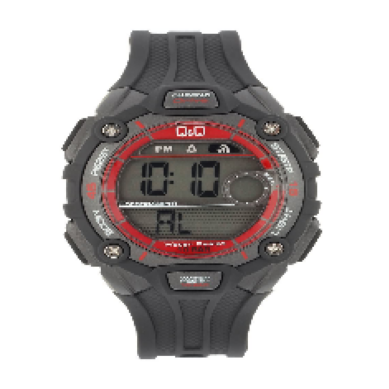

In [43]:
# plot some samples
img = images_sml_cls[0]
plt.imshow(img)
plt.axis("off")
plt.show()

## 1.3 large classes

In [44]:
keep_df_lrg_cls=pd.DataFrame()
for i in range(4):
    idx = styles_df[styles_df['masterCategory']==cats[i]].sample(1000,random_state=42).index
    keep_df_lrg_cls=pd.concat([keep_df_lrg_cls,styles_df.loc[idx.values,:]])
#
keep_df_lrg_cls.shape

(4000, 9)

In [45]:
prod_id_lrg_cls = keep_df_lrg_cls.index.to_numpy()

In [46]:
len(prod_id_lrg_cls)

4000

## 1.4 Import Images for large classes

In [47]:
images_lrg_cls = load_imgs(prod_id_lrg_cls)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:32<00:00, 43.03it/s]


In [48]:
gc.collect()

2132

In [49]:
images_lrg_cls.shape

(4000, 224, 224, 3)

In [50]:
X=np.vstack((images_sml_cls,images_lrg_cls))
X= preprocess_input(X) 

In [51]:
prod_id=np.concatenate((prod_id_sml_cls,prod_id_lrg_cls))

In [52]:
np.save('prod_id', prod_id)

# 2. Import Data From files

In [53]:
i_load_X=0

if i_load_X==1:
    X_train = np.load('X_train.npy')
    X_test = np.load('X_test.npy')
    X=np.vstack((X_train,X_test))
    
    prod_id=np.load('prod_id.npy')

In [96]:
X.shape, prod_id.shape

((4131, 224, 224, 3), (4131,))

# 3. Build vgg16 Model for feature extraction

In [55]:
vgg_model = VGG16(weights="imagenet")
#with vgg model (or any model above)
image_width = eval(str(vgg_model.layers[0].output.shape[1]))
image_height = eval(str(vgg_model.layers[0].output.shape[2]))

In [56]:
image_width,image_height

(224, 224)

In [97]:
feat_extract = Model(inputs=vgg_model.input,outputs=vgg_model.layers[-2].output)
feat_extract.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [64]:
#save feature scores into file for later import

i_load_features=1
if i_load_features==1:
    imgs_features = np.load('imgs_features.npy')
else:
    imgs_features = feat_extract.predict(X)

# 4 Calculate Similarities

In [ ]:
cosSimilarities = cosine_similarity(imgs_features)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=prod_id, index=prod_id)
sim_table=cos_similarities_df

In [73]:
sim_table.head()

,53598,49696,53591,45894,53596,52676,29975,29981,51091,54970,...,20075,56461,49125,57765,55138,56385,56506,56454,55119,55146
53598,1.000000,0.163672,0.325512,0.475173,0.812320,0.529992,0.292442,0.382381,0.123258,0.198812,...,0.135663,0.184252,0.244325,0.220878,0.193784,0.168745,0.125128,0.188619,0.279748,0.193239
49696,0.163672,1.000000,0.286695,0.277203,0.223055,0.202498,0.290919,0.306177,0.425483,0.319497,...,0.273677,0.327000,0.351943,0.281038,0.351843,0.278669,0.443953,0.349477,0.361502,0.262411
53591,0.325512,0.286695,1.000000,0.728890,0.396740,0.522554,0.336436,0.472001,0.187927,0.291986,...,0.268540,0.314692,0.418310,0.303961,0.296453,0.304336,0.244209,0.331631,0.292156,0.289274
45894,0.475173,0.277203,0.728890,1.000000,0.527852,0.513344,0.373943,0.449632,0.149312,0.305533,...,0.221413,0.254868,0.372380,0.342737,0.301902,0.258094,0.180034,0.276736,0.301650,0.264080
53596,0.812320,0.223055,0.396740,0.527852,1.000000,0.604705,0.320827,0.389656,0.133229,0.239906,...,0.173665,0.219757,0.296165,0.248442,0.233570,0.205163,0.169521,0.225969,0.323262,0.216017


In [74]:
imgs_features[0]

array([4.4198284 , 0.        , 0.        , ..., 0.        , 0.        ,
       0.20219299], dtype=float32)

In [62]:
imgs_features.shape

(4131, 4096)

In [63]:
np.save('imgs_features', imgs_features)

In [66]:
np.savetxt("imgs_features.csv",imgs_features,delimiter = ",")

# 5. Find The Closest Top Few Products for A Given One

In [88]:
image_path = 'fashion-dataset/images/'

def most_similar_to(image_name, n= 5):
    
    original = image.load_img(f'{image_path}{image_name}.jpg', color_mode='rgb',target_size=(image_width,image_height))
    plt.imshow(original)
    plt.axis("off")
    plt.show()

    closest_imgs = sim_table[image_name].sort_values(ascending=False)[1:n+1].index
    closest_imgs_scores = sim_table[image_name].sort_values(ascending=False)[1:n+1]

    for i in range(0,len(closest_imgs)):
        original = image.load_img(f'{image_path}{closest_imgs[i]}.jpg', color_mode='rgb',
                                  target_size=(image_width,image_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores.iloc[i])

# 6. Testing Model

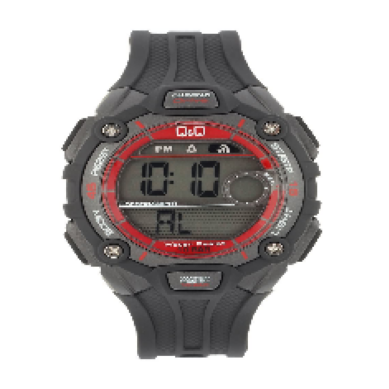

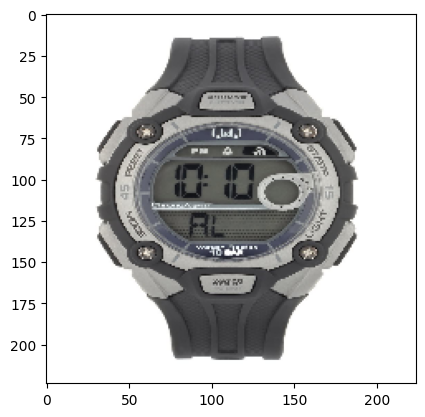

similarity score :  0.9191196


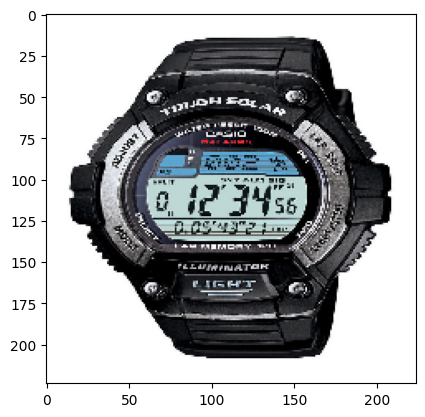

similarity score :  0.81778395


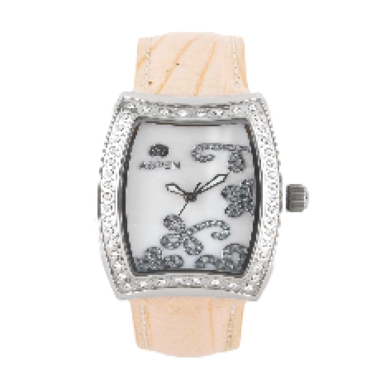

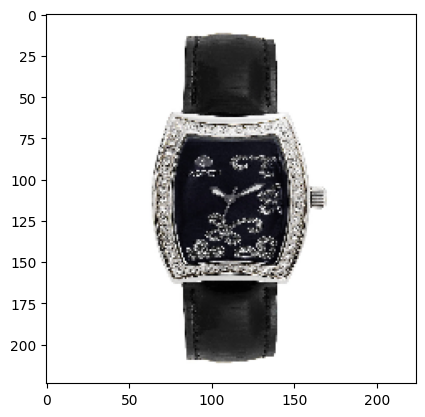

similarity score :  0.6544407


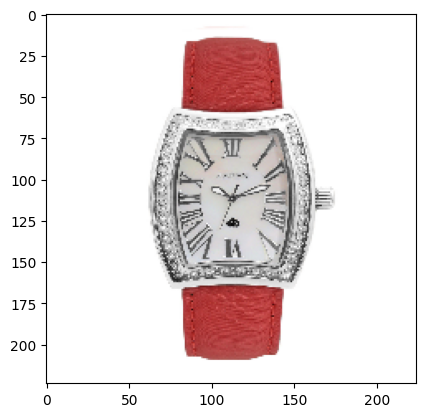

similarity score :  0.61666507


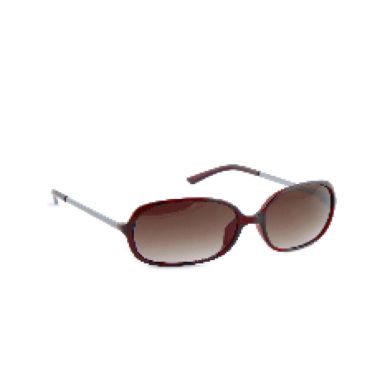

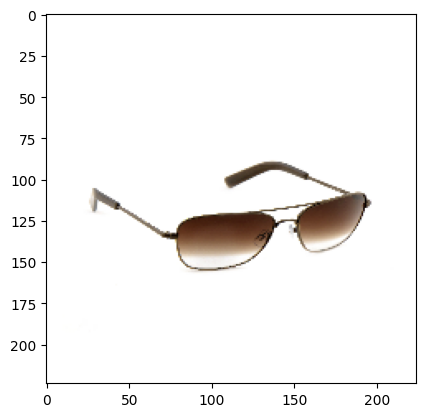

similarity score :  0.9165741


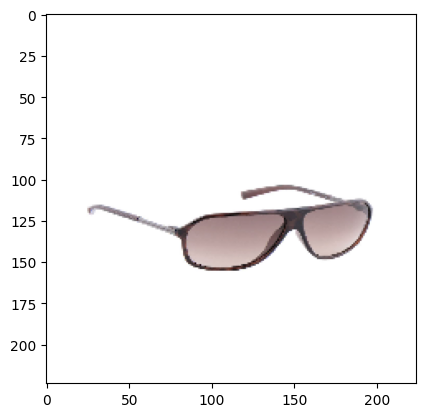

similarity score :  0.90941095


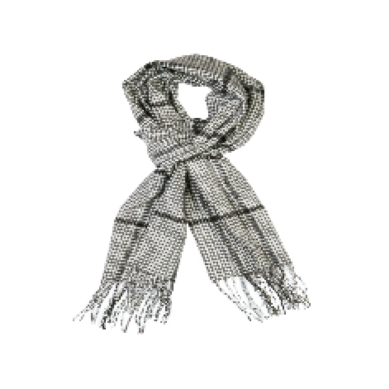

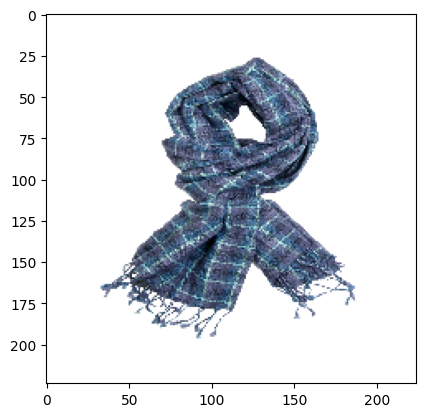

similarity score :  0.75814235


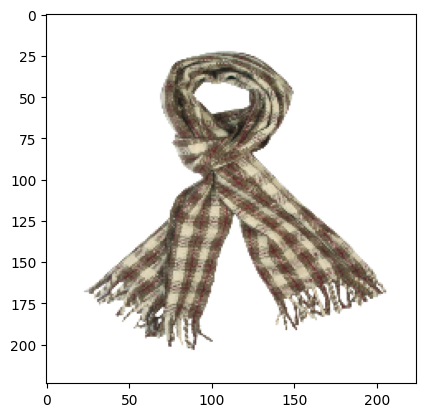

similarity score :  0.6847653


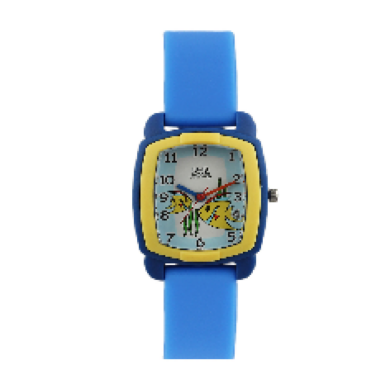

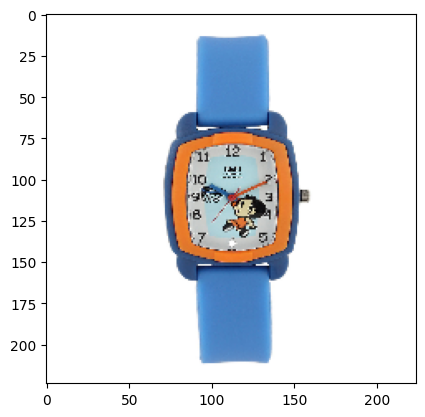

similarity score :  0.9471097


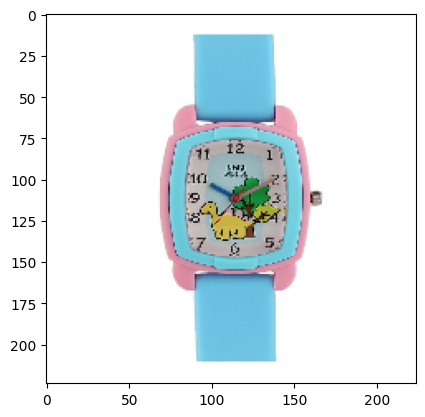

similarity score :  0.8279457


In [95]:
given_imgs=[53598, 29983, 16937, 23482, 53567]

for image_name in given_imgs:
    most_similar_to(image_name,n=2)